In [1]:
import pandas

import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

Definisanje globalnih promenljivih za lakse menjanje

In [2]:
PUTANJA = 'C:/Users/User/Desktop/AI'
KATEGORIJE = ['ZDRAV', 'VIRUS', 'BAKTERIJA', 'STREPTOCOCCUS', 'COVID-19', 'ARDS', 'SARS']
IMG_SIZE = 400

In [3]:
from tensorflow.keras.callbacks import TensorBoard
import time

IME = "Model-Pluca-9x2-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(IME))

Pravljenje niza labela "train_y" i punimo ga brojevnim reprezentacijama zadatih kategorija

In [4]:
csv_fajl = pandas.read_csv(PUTANJA + r"\chest_xray_metadata.csv")  # promeniti na svoju lokaciju

# uklanjamo pusace zbog manjka slika (takodje je tako navedeno u zadatku)

train_y = np.ndarray(0)

for index, row in csv_fajl.iterrows():
    if row['Label'] != 'Normal':
        if str(row['Label_2_Virus_category']) != 'nan':
            if row['Label_2_Virus_category'] == 'Streptococcus':
                #csv_fajl.at[str(index), 'Label'] = 3
                train_y = np.append(train_y, 3)
                #row['Label'] = 3
            elif row['Label_2_Virus_category'] == 'COVID-19':
                #csv_fajl.at[str(index), 'Label'] = 4
                train_y = np.append(train_y, 4)
                #row['Label'] = 4
            elif row['Label_2_Virus_category'] == 'ARDS':
                #csv_fajl.at[str(index), 'Label'] = 5
                train_y = np.append(train_y, 5)
                #row['Label'] = 5
            elif row['Label_2_Virus_category'] == 'SARS':
                #csv_fajl.at[str(index), 'Label'] = 6
                train_y = np.append(train_y, 6)
                #row['Label'] = 6
            else:
                print('promaseno ' + row['Label_2_Virus_category'])
            # print(row['Label'], " => " , row['Label_1_Virus_category'], "|", row['Label_2_Virus_category'])#, row['X_ray_image_name'])
        else:
            if row['Label_1_Virus_category'] == 'Virus':
                #csv_fajl.at[str(index), 'Label'] = 1
                train_y = np.append(train_y, 1)
                #row['Label'] = 1
            elif row['Label_1_Virus_category'] == 'bacteria':
                #csv_fajl.at[str(index), 'Label'] = 2
                train_y = np.append(train_y, 2)
                #row['Label'] = 2
            else:
                print('promaseno ' + row['Label_1_Virus_category'])
            # print(row['Label'], " => " , row['Label_1_Virus_category'], "|", row['Label_2_Virus_category'])#, row['X_ray_image_name'])
    else:
        #csv_fajl.at[str(index), 'Label'] = 0
        train_y = np.append(train_y, 0)
        #row['Label'] = 0

In [5]:
csv_fajl.head()
training_data = []

for index, row in csv_fajl.iterrows():
    img_name = row['X_ray_image_name']
    lokacija = PUTANJA + '/snimci/' + str(img_name)
    try:# za slucaj da neka slika ostecena 
        slika = cv2.imread(lokacija, cv2.IMREAD_GRAYSCALE)
        slika = cv2.resize(slika, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
        training_data.append([slika, int(train_y[index])])
    except:
        print("Ostecena slika " + str(img_name))

In [6]:
print(len(training_data))
"""
for index, row in csv_fajl.iterrows():
    img_name = row['X_ray_image_name']
    lokacija = PUTANJA + '/snimci/' + str(img_name)
    try:# za slucaj da neka slika ostecena 
        slika = cv2.imread(lokacija, cv2.IMREAD_GRAYSCALE)
        slika = cv2.resize(slika, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
        print(str(train_y[index]) + " ==> " + str(img_name))
    except:
        print("Ostecena slika " + str(img_name))
"""

5286


'\nfor index, row in csv_fajl.iterrows():\n    img_name = row[\'X_ray_image_name\']\n    lokacija = PUTANJA + \'/snimci/\' + str(img_name)\n    try:# za slucaj da neka slika ostecena \n        slika = cv2.imread(lokacija, cv2.IMREAD_GRAYSCALE)\n        slika = cv2.resize(slika, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)\n        print(str(train_y[index]) + " ==> " + str(img_name))\n    except:\n        print("Ostecena slika " + str(img_name))\n'

In [6]:
import random

random.shuffle(training_data)

In [7]:
X = []
y = []

In [8]:
for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [9]:
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

Kreiranje CNN-a

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [11]:
import pickle
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

X = X/255.0

In [13]:
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Trenutni META
####################### 
from tensorflow.keras.optimizers import RMSprop
model = tf.keras.models.Sequential([
  
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    # model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
    tf.keras.layers.Flatten(input_shape = X.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7)
])

####### to get the summary of the model
model.summary()

####### configure the model for traning by adding metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )
#######################

# Ne radi
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

In [12]:
from tensorflow.keras.optimizers import RMSprop

dense_layers = [0]
layer_sizes = [32]
conv_layers = [1]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-dense---{}-nodes---{}-conv---{}".format(dense_layer, layer_size, conv_layer, int(time.time()))
            tensorboard = TensorBoard(log_dir='logs_test/{}'.format(IME))
            print(NAME)

            model = tf.keras.models.Sequential()
            
            model.add(Conv2D(layer_size, (3, 3), input_shape = X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))
            
            model.add(Flatten())
            
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))
            
            
            model.add(Dense(7))

            model.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy']
            )
            model.fit(np.array(X), np.array(y), batch_size=9,  epochs=5, validation_split=0.1, callbacks=[tensorboard])

0-dense---32-nodes---1-conv---1596108997
Epoch 1/5
529/529 [==============================] - 148s 280ms/step - loss: 1.2736 - accuracy: 0.7261 - val_loss: 0.6181 - val_accuracy: 0.7486
Epoch 2/5
529/529 [==============================] - 143s 270ms/step - loss: 0.3845 - accuracy: 0.8449 - val_loss: 0.6042 - val_accuracy: 0.7618
Epoch 3/5
529/529 [==============================] - 143s 270ms/step - loss: 0.2323 - accuracy: 0.9104 - val_loss: 0.5237 - val_accuracy: 0.7788
Epoch 4/5
529/529 [==============================] - 142s 269ms/step - loss: 0.2543 - accuracy: 0.9121 - val_loss: 0.6208 - val_accuracy: 0.7656
Epoch 5/5
529/529 [==============================] - 142s 268ms/step - loss: 0.1451 - accuracy: 0.9510 - val_loss: 0.5785 - val_accuracy: 0.7958


# model.fit(np.array(X), np.array(y), batch_size=9,  epochs=2, validation_split=0.1, callbacks=[tensorboard])

In [13]:
model.fit(np.array(X), np.array(y), batch_size=9,  epochs=5, validation_split=0.1, callbacks=[tensorboard])
X = []
y = []

Epoch 1/2
529/529 [==============================] - 156s 296ms/step - loss: 0.0617 - accuracy: 0.9857 - val_loss: 0.6845 - val_accuracy: 0.7826
Epoch 2/2
529/529 [==============================] - 144s 272ms/step - loss: 0.0482 - accuracy: 0.9908 - val_loss: 0.7369 - val_accuracy: 0.7694


In [37]:
# model.save('saved_model\\99')

INFO:tensorflow:Assets written to: saved_model\99\assets


za 400:
    Epoch 1/10
    529/529 518s 979ms/step - loss: 1.5214e-07 - accuracy: 0.2466 - val_loss: 1.3859e-07 - val_accuracy: 0.3119
    Epoch 2/10
    529/529 507s 958ms/step - loss: 1.5214e-07 - accuracy: 0.2466 - val_loss: 1.3859e-07 - val_accuracy: 0.3119
    
za 350:
    Epoch 1/10
    529/529 394s 745ms/step - loss: 1.4998e-07 - accuracy: 0.2527 - val_loss: 1.5797e-07 - val_accuracy: 0.2212

In [ ]:
''' #conv i dense su zamenjeni
0-conv---32-nodes---1-dense---1595918749
Epoch 1/2
  2/529 [..............................] - ETA: 5:37 - loss: 13.7277 - accuracy: 0.2778WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.579315). Check your callbacks.
529/529 [==============================] - 78s 148ms/step - loss: 1.1279 - accuracy: 0.7305 - val_loss: 0.4849 - val_accuracy: 0.7958
Epoch 2/2
529/529 [==============================] - 77s 145ms/step - loss: 0.3876 - accuracy: 0.8400 - val_loss: 0.5005 - val_accuracy: 0.7788
0-conv---32-nodes---2-dense---1595918911
Epoch 1/2
  2/529 [..............................] - ETA: 6:36 - loss: 2.6182 - accuracy: 0.2222  WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.639454). Check your callbacks.
529/529 [==============================] - 130s 247ms/step - loss: 0.6906 - accuracy: 0.7219 - val_loss: 0.5290 - val_accuracy: 0.7543
Epoch 2/2
529/529 [==============================] - 127s 240ms/step - loss: 0.4883 - accuracy: 0.7965 - val_loss: 0.5098 - val_accuracy: 0.7750
0-conv---32-nodes---3-dense---1595919185
Epoch 1/2
  2/529 [..............................] - ETA: 28:20 - loss: 1.6812 - accuracy: 0.2222 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (3.884267). Check your callbacks.
  3/529 [..............................] - ETA: 19:36 - loss: 1.8325 - accuracy: 0.2222WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (3.170902). Check your callbacks.
  4/529 [..............................] - ETA: 15:14 - loss: 1.7329 - accuracy: 0.3056WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.585950). Check your callbacks.
529/529 [==============================] - 149s 282ms/step - loss: 0.6922 - accuracy: 0.7072 - val_loss: 0.5050 - val_accuracy: 0.7826
Epoch 2/2
529/529 [==============================] - 138s 262ms/step - loss: 0.4884 - accuracy: 0.7917 - val_loss: 0.4616 - val_accuracy: 0.7996
0-conv---64-nodes---1-dense---1595919881
Epoch 1/2
  2/529 [..............................] - ETA: 15:05 - loss: 1.2220 - accuracy: 0.4444WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.875274). Check your callbacks.
  3/529 [..............................] - ETA: 11:07 - loss: 1.5099 - accuracy: 0.5185WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.977435). Check your callbacks.
  4/529 [..............................] - ETA: 8:57 - loss: 8.1165 - accuracy: 0.4167 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.489217). Check your callbacks.
529/529 [==============================] - 157s 297ms/step - loss: 1.1844 - accuracy: 0.7244 - val_loss: 0.5493 - val_accuracy: 0.7580
Epoch 2/2
529/529 [==============================] - 154s 292ms/step - loss: 0.3973 - accuracy: 0.8343 - val_loss: 0.5036 - val_accuracy: 0.7902
0-conv---64-nodes---2-dense---1595920347
Epoch 1/2
  2/529 [..............................] - ETA: 12:34 - loss: 2.9759 - accuracy: 0.1667 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.231208). Check your callbacks.
529/529 [==============================] - 266s 503ms/step - loss: 0.6934 - accuracy: 0.7271 - val_loss: 0.5445 - val_accuracy: 0.7826
Epoch 2/2
529/529 [==============================] - 261s 493ms/step - loss: 0.4769 - accuracy: 0.8001 - val_loss: 0.5115 - val_accuracy: 0.7807
0-conv---64-nodes---3-dense---1595921035
Epoch 1/2
  2/529 [..............................] - ETA: 10:17 - loss: 1.5227 - accuracy: 0.2778WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.054166). Check your callbacks.
529/529 [==============================] - 293s 554ms/step - loss: 0.7026 - accuracy: 0.7042 - val_loss: 0.6996 - val_accuracy: 0.6975
Epoch 2/2
529/529 [==============================] - 281s 532ms/step - loss: 0.5167 - accuracy: 0.7803 - val_loss: 0.4647 - val_accuracy: 0.7921
0-conv---128-nodes---1-dense---1595921841
Epoch 1/2
  2/529 [..............................] - ETA: 16:24 - loss: 8.4130 - accuracy: 0.3333 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.664864). Check your callbacks.
529/529 [==============================] - 323s 611ms/step - loss: 1.6026 - accuracy: 0.7194 - val_loss: 0.5205 - val_accuracy: 0.7902
Epoch 2/2
529/529 [==============================] - 313s 592ms/step - loss: 0.4310 - accuracy: 0.8226 - val_loss: 0.5366 - val_accuracy: 0.7750
0-conv---128-nodes---2-dense---1595922863
Epoch 1/2
  2/529 [..............................] - ETA: 12:51 - loss: 3.6535 - accuracy: 0.2222WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.211521). Check your callbacks.
529/529 [==============================] - 568s 1s/step - loss: 0.7377 - accuracy: 0.7030 - val_loss: 0.5345 - val_accuracy: 0.7694
Epoch 2/2
529/529 [==============================] - 550s 1s/step - loss: 0.4739 - accuracy: 0.8016 - val_loss: 0.5118 - val_accuracy: 0.7694
0-conv---128-nodes---3-dense---1595924202
Epoch 1/2
  2/529 [..............................] - ETA: 31:55 - loss: 2.1914 - accuracy: 0.2778WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (3.035765). Check your callbacks.
  3/529 [..............................] - ETA: 27:51 - loss: 1.8927 - accuracy: 0.2963WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (2.244955). Check your callbacks.
 56/529 [==>...........................] - ETA: 13:38 - loss: 1.0876 - accuracy: 0.5258
 '''

'''
0-coonv---32-nodes---1-dense---1595918749
529/529 [==============================] - 77s 145ms/step - loss: 0.3876 - accuracy: 0.8400 - val_loss: 0.5005 - val_accuracy: 0.7788

0-coonv---32-nodes---2-dense---1595918911
529/529 [==============================] - 127s 240ms/step - loss: 0.4883 - accuracy: 0.7965 - val_loss: 0.5098 - val_accuracy: 0.7750

0-coonv---32-nodes---3-dense---1595919185
529/529 [==============================] - 138s 262ms/step - loss: 0.4884 - accuracy: 0.7917 - val_loss: 0.4616 - val_accuracy: 0.7996

0-coonv---64-nodes---1-dense---1595919881
529/529 [==============================] - 154s 292ms/step - loss: 0.3973 - accuracy: 0.8343 - val_loss: 0.5036 - val_accuracy: 0.7902

0-coonv---64-nodes---2-dense---1595920347
529/529 [==============================] - 261s 493ms/step - loss: 0.4769 - accuracy: 0.8001 - val_loss: 0.5115 - val_accuracy: 0.7807

0-coonv---64-nodes---3-dense---1595921035
529/529 [==============================] - 281s 532ms/step - loss: 0.5167 - accuracy: 0.7803 - val_loss: 0.4647 - val_accuracy: 0.7921

0-coonv---128-nodes---1-dense---1595921841
529/529 [==============================] - 313s 592ms/step - loss: 0.4310 - accuracy: 0.8226 - val_loss: 0.5366 - val_accuracy: 0.7750

0-coonv---128-nodes---2-dense---1595922863
529/529 [==============================] - 550s 1s/step - loss: 0.4739 - accuracy: 0.8016 - val_loss: 0.5118 - val_accuracy: 0.7694

0-coonv---128-nodes---3-dense---1595924202
Epoch 1/2
  2/529 [..............................] - ETA: 31:55 - loss: 2.1914 - accuracy: 0.2778WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (3.035765). Check your callbacks.
  3/529 [..............................] - ETA: 27:51 - loss: 1.8927 - accuracy: 0.2963WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (2.244955). Check your callbacks.
 56/529 [==>...........................] - ETA: 13:38 - loss: 1.0876 - accuracy: 0.5258
'''

# Koriscenje modela

In [38]:
model = tf.keras.models.load_model('saved_model\\99')# kod za ucitavanje modela koji se nalazi u folderu saved_model koji sadrzi folder 0-dense---32-nodes---1-conv---accuracy-95_08

In [7]:
model.summary()# da proverimo da li je model dobro ucitan/sacuvan

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 398, 398, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1267232)           0         
_________________________________________________________________
dense (Dense)                (None, 7)                 8870631   
Total params: 8,870,951
Trainable params: 8,870,951
Non-trainable params: 0
_________________________________________________________________


In [39]:
IMG_LOCATION = 'C:/Users/User/Desktop/xray.jpg'

Model je misli da je u pitanju BAKTERIJA


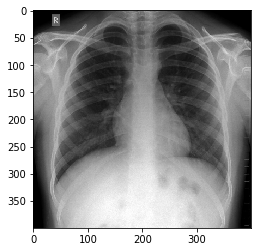

In [44]:
test_slika = cv2.imread(IMG_LOCATION, cv2.IMREAD_GRAYSCALE)
test_slika = cv2.resize(test_slika, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
plt.imshow(test_slika, cmap='gray')

test_slika = np.array(test_slika)
test_slika = (np.expand_dims(test_slika, 0))
test_slika = (np.expand_dims(test_slika,-1))

prediction = model.predict(test_slika)
print("Model je misli da je u pitanju {}".format(KATEGORIJE[np.argmax(prediction[0])]))

In [41]:
csv_fajl = pandas.read_csv(PUTANJA + r"\chest_xray_metadata.csv")  # promeniti na svoju lokaciju

# uklanjamo pusace zbog manjka slika (takodje je tako navedeno u zadatku)

train_y = np.ndarray(0)
ssi = 0
for index, row in csv_fajl.iterrows():
    if ssi < 11:
        if row['Label'] != 'Normal':
            if str(row['Label_2_Virus_category']) != 'nan':
                if row['Label_2_Virus_category'] == 'Streptococcus':
                    #csv_fajl.at[str(index), 'Label'] = 3
                    train_y = np.append(train_y, 3)
                    #row['Label'] = 3
                elif row['Label_2_Virus_category'] == 'COVID-19':
                    #csv_fajl.at[str(index), 'Label'] = 4
                    train_y = np.append(train_y, 4)
                    #row['Label'] = 4
                elif row['Label_2_Virus_category'] == 'ARDS':
                    #csv_fajl.at[str(index), 'Label'] = 5
                    train_y = np.append(train_y, 5)
                    #row['Label'] = 5
                elif row['Label_2_Virus_category'] == 'SARS':
                    #csv_fajl.at[str(index), 'Label'] = 6
                    train_y = np.append(train_y, 6)
                    #row['Label'] = 6
                else:
                    print('promaseno ' + row['Label_2_Virus_category'])
                # print(row['Label'], " => " , row['Label_1_Virus_category'], "|", row['Label_2_Virus_category'])#, row['X_ray_image_name'])
            else:
                if row['Label_1_Virus_category'] == 'Virus':
                    #csv_fajl.at[str(index), 'Label'] = 1
                    train_y = np.append(train_y, 1)
                    #row['Label'] = 1
                elif row['Label_1_Virus_category'] == 'bacteria':
                    #csv_fajl.at[str(index), 'Label'] = 2
                    train_y = np.append(train_y, 2)
                    #row['Label'] = 2
                else:
                    print('promaseno ' + row['Label_1_Virus_category'])
                # print(row['Label'], " => " , row['Label_1_Virus_category'], "|", row['Label_2_Virus_category'])#, row['X_ray_image_name'])
        else:
            #csv_fajl.at[str(index), 'Label'] = 0
            train_y = np.append(train_y, 0)
            #row['Label'] = 0
        
csv_fajl.head()
training_data = []

for index, row in csv_fajl.iterrows():
    img_name = row['X_ray_image_name']
    lokacija = PUTANJA + '/snimci/' + str(img_name)
    test_slika = cv2.imread(lokacija, cv2.IMREAD_GRAYSCALE)
    test_slika = cv2.resize(test_slika, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    test_slika = np.array(test_slika)
    test_slika = (np.expand_dims(test_slika, 0))
    test_slika = (np.expand_dims(test_slika,-1))

    prediction = model.predict(test_slika)
    
    if int(np.argmax(prediction[0])) != int(train_y[index]):
        print(prediction[0])
        print("{} == {}".format(KATEGORIJE[np.argmax(int(train_y[index]))], KATEGORIJE[np.argmax(prediction[0])]))

        




[ 2342.0054  2034.4946  2884.9639 -7164.427  -5826.418  -7712.5005
 -5300.127 ]
ZDRAV == BAKTERIJA
[ 1997.4377  1459.1357  2858.32   -7226.157  -4202.155  -7982.9204
 -2164.4575]
ZDRAV == BAKTERIJA
[ 2483.4673   1020.95197  2623.1682  -6437.0996  -6397.2144  -7722.282
 -4445.856  ]
ZDRAV == BAKTERIJA
[  1688.7593     130.19072   2000.1737   -9838.056    -7321.6987
 -10578.596    -7352.842  ]
ZDRAV == BAKTERIJA
[  1300.6273    852.123    1930.8611 -10012.1455  -5018.0547 -12052.084
  -3020.9216]
ZDRAV == BAKTERIJA
[ 2278.612    1409.7352   2631.418   -5370.728   -2951.3467  -6904.8335
   784.90607]
ZDRAV == BAKTERIJA
[ 1675.1439  1087.2506  2083.3374 -8288.572  -6357.6763 -9561.73
 -5951.6055]
ZDRAV == BAKTERIJA
[ 2199.42     -552.91156  2571.8904  -7649.158   -6766.9233  -8955.648
 -7023.4346 ]
ZDRAV == BAKTERIJA
[  699.74194   783.7131   2468.1992  -7258.0874  -4668.96    -9115.488
 -1920.8242 ]
ZDRAV == BAKTERIJA
[ 2552.9062  1164.6272  2835.003  -7870.439  -6383.8574 -8640.827
 -567

[ 1854.8599  1289.4539  2980.5825 -8060.5835 -7115.613  -9498.822
 -6978.304 ]
ZDRAV == BAKTERIJA
[ 1669.1771  1602.8505  1700.0629 -6793.965  -6426.7593 -7980.0825
 -5697.5273]
ZDRAV == BAKTERIJA
[ 2045.7072   907.1907  2115.0469 -7586.74   -7212.5    -9325.543
 -6646.7144]
ZDRAV == BAKTERIJA
[ 2428.8809  1044.0455  2953.4238 -6980.245  -6031.8193 -7751.673
 -5849.866 ]
ZDRAV == BAKTERIJA
[  2262.6455     423.84412   2298.3574   -8362.481    -4820.8716
 -10253.951    -4395.593  ]
ZDRAV == BAKTERIJA
[ -121.96886  1936.813    3099.4487  -7525.5137  -5889.4766  -9111.125
 -5744.4536 ]
ZDRAV == BAKTERIJA
[ -1219.6339   2911.8196   2964.1897  -9713.657   -7966.977  -10957.447
  -7971.7188]
ZDRAV == BAKTERIJA
[-2108.988   2168.4736  2442.069  -7242.5146 -5904.1523 -9625.962
 -5842.84  ]
ZDRAV == BAKTERIJA
[ -1519.6462   2909.6765   3110.5662  -8774.96    -8561.343  -10061.059
  -8230.752 ]
ZDRAV == BAKTERIJA
[ -844.85724  2315.4014   2346.8743  -7639.3086  -6600.6343  -8671.804
 -4576.3716 

[  241.6235  2825.6543  3602.0422 -5214.2993 -3792.7156 -7089.7017
 -1187.7273]
ZDRAV == BAKTERIJA
[-1189.5328  2426.9177  3034.3186 -5212.984  -5694.9355 -5895.1216
 -3970.0798]
ZDRAV == BAKTERIJA
[-1711.1758  2628.609   3211.7688 -7587.737  -6319.117  -9444.081
 -6513.8296]
ZDRAV == BAKTERIJA
[  440.43686  3353.257    3358.155   -7234.7236  -5601.0283  -8856.794
 -3815.039  ]
ZDRAV == BAKTERIJA
[ -742.1598  2249.4368  3063.2527 -5509.4976 -4597.925  -6987.5137
 -2954.0437]
ZDRAV == BAKTERIJA
[ -587.35547  2721.937    2793.6582  -5825.864   -6140.825   -7363.3643
 -3775.6758 ]
ZDRAV == BAKTERIJA
[-1732.7896  3058.8147  3537.2415 -8435.955  -7818.1436 -9229.896
 -5849.3667]
ZDRAV == BAKTERIJA
[  -873.443    3130.11     3227.4692  -9075.038   -8101.7466 -10082.074
  -6312.3296]
ZDRAV == BAKTERIJA
[-1664.2904  1192.5759  2474.5989 -7683.126  -5486.214  -8635.398
 -6122.0186]
ZDRAV == BAKTERIJA
[-2150.6116  2483.5737  2662.267  -8955.796  -6528.8696 -9024.281
 -4189.215 ]
ZDRAV == BAKTERI

[ -996.632   1430.8403  2890.0715 -5924.873  -5673.3135 -7807.712
 -5923.996 ]
ZDRAV == BAKTERIJA
[  968.7672   3373.7231   3842.6477  -5958.059   -4459.9663  -7822.779
  -543.47076]
ZDRAV == BAKTERIJA
[  633.858   2388.382   2563.307  -7807.7134 -6228.2314 -9056.377
 -6329.093 ]
ZDRAV == BAKTERIJA
[-1426.1884  2415.8652  2802.337  -8394.308  -5857.957  -9720.542
 -6221.9917]
ZDRAV == BAKTERIJA
[  -822.85187   2410.3623    2962.071    -8324.821    -5651.1855
 -10474.425    -4902.3315 ]
ZDRAV == BAKTERIJA
[  -51.35878  2224.5422   3054.4268  -4936.988   -3352.902   -6404.332
  -408.0561 ]
ZDRAV == BAKTERIJA
[  621.82513  2276.0435   3778.9973  -7397.7446  -5832.77    -7489.0767
 -6030.584  ]
ZDRAV == BAKTERIJA
[ -108.51914  3044.7517   3422.149   -6732.7964  -4851.6455  -8661.394
 -2540.0984 ]
ZDRAV == BAKTERIJA
[-1634.7062  2126.3267  2418.3796 -6965.684  -5119.184  -8335.22
 -5146.1616]
ZDRAV == BAKTERIJA
[ -752.2418  2574.9548  2753.3804 -6747.136  -5568.048  -8035.538
 -3714.6147]
Z

[ -3919.3428   2690.353    2925.9553  -9122.071   -8318.966  -12456.411
  -6470.794 ]
ZDRAV == BAKTERIJA
[  218.55284  3012.9617   3009.5623  -6952.6655  -6058.0386  -7445.803
 -3575.9485 ]
ZDRAV == VIRUS
[ -990.99384  3032.8418   2426.3655  -8310.9795  -7779.3774  -8712.26
 -7138.7305 ]
ZDRAV == VIRUS
[ -243.92944  2852.7642   2663.3997  -7692.556   -7558.646   -9053.465
 -7513.409  ]
ZDRAV == VIRUS
[-1027.4827  2588.085   3152.7495 -6833.352  -5783.9604 -8094.663
 -4928.748 ]
ZDRAV == BAKTERIJA
[ -2249.547    1531.6985   3779.8772 -10970.64    -9689.638  -11924.935
  -9506.132 ]
ZDRAV == BAKTERIJA
[ -198.20189  2548.775    2743.6714  -7689.0923  -6349.4277  -8062.081
 -5170.937  ]
ZDRAV == BAKTERIJA
[ -1615.8431   2096.613    2661.1902 -10255.259   -8703.918  -12253.4375
  -8623.051 ]
ZDRAV == BAKTERIJA
[ 1321.9703  2767.679   2835.6292 -5023.828  -4380.3115 -6363.9004
 -2391.1245]
ZDRAV == BAKTERIJA
[ 1102.0525  2974.5037  3351.7512 -5004.17   -4341.1304 -5253.3765
  -666.3843]
ZDRA

[ -951.75287  1125.218    1463.8254  -7437.48    -5112.806   -8625.147
 -6126.6143 ]
ZDRAV == BAKTERIJA
[ -957.5196  2008.0984  2022.0798 -8180.194  -6997.624  -9348.232
 -7136.5156]
ZDRAV == BAKTERIJA
[ -462.2074  2005.4913  2243.6978 -5906.946  -4250.4126 -6259.4814
 -2861.2915]
ZDRAV == BAKTERIJA
[   92.60073  1558.8861   2255.724   -7199.0767  -6838.1133  -8422.932
 -6320.429  ]
ZDRAV == BAKTERIJA
[  419.20575  2964.3542   2986.1978  -6749.4414  -4352.8774  -6849.825
 -1707.5868 ]
ZDRAV == BAKTERIJA
[ -335.02808  2424.9656   2617.3691  -7252.825   -5011.821   -7938.0947
 -2981.0999 ]
ZDRAV == BAKTERIJA
[  849.7702  2587.0603  2603.1187 -7869.685  -7769.997  -8869.16
 -6418.735 ]
ZDRAV == BAKTERIJA
[ -129.1636  1416.1676  1427.0048 -5546.0312 -3090.9897 -5948.6045
 -2331.2861]
ZDRAV == BAKTERIJA
[  269.56616  2189.5903   2348.434   -5496.689   -4033.3442  -6154.56
 -2257.6963 ]
ZDRAV == BAKTERIJA
[  450.10684  2337.4763   3223.0483  -4242.4185  -2450.1128  -6178.7227
   370.78534]
Z

[ -665.8321  2892.4097  3265.569  -7462.8525 -5556.0776 -8884.051
 -3736.49  ]
ZDRAV == BAKTERIJA
[-1866.4946  2146.047   2573.3596 -8151.3613 -7685.587  -9987.414
 -8030.6294]
ZDRAV == BAKTERIJA
[  941.1307  2146.046   2685.9006 -4056.7717 -3815.9922 -4934.465
 -1465.2041]
ZDRAV == BAKTERIJA
[ -151.28899  2296.1545   2365.6775  -5983.038   -4951.5737  -7007.806
 -3680.0186 ]
ZDRAV == BAKTERIJA
[-1246.2964  2715.924   3304.993  -8458.572  -6566.6265 -9880.814
 -6517.449 ]
ZDRAV == BAKTERIJA
[  -873.9806   2367.3928   3698.0974  -8984.785   -7734.6045 -10348.764
  -7240.302 ]
ZDRAV == BAKTERIJA
[  491.65457  2310.009    2648.2065  -6456.6973  -5329.621   -7237.7817
 -4928.746  ]
ZDRAV == BAKTERIJA
[-2159.0408  2278.8503  2437.8123 -7004.9004 -5646.336  -8226.897
 -6128.5376]
ZDRAV == BAKTERIJA
[  -68.27107  2874.6653   2955.598   -6391.355   -3279.827   -8011.1196
   383.85416]
ZDRAV == BAKTERIJA
[  382.52176  2339.2424   2912.5251  -7397.7334  -7776.676   -8644.285
 -6459.2876 ]
ZDRAV 

[  -13.396083  1836.9553    2443.0208   -4904.4062   -4564.009
 -5735.383    -2874.7417  ]
ZDRAV == BAKTERIJA
[ -407.98016  2516.0278   2529.536   -8520.83    -7491.0024  -8934.6875
 -6763.634  ]
ZDRAV == BAKTERIJA
[  368.455    2820.5442   3104.765   -4958.306   -2748.7856  -6024.0005
   746.48627]
ZDRAV == BAKTERIJA
[  370.67554  2378.823    2707.1824  -6967.283   -6433.3535  -7603.12
 -5915.7686 ]
ZDRAV == BAKTERIJA
[   15.340016  1488.5647    1945.6008   -7605.424    -6584.6265
 -9420.963    -7189.018   ]
ZDRAV == BAKTERIJA
[ -403.18903  1812.968    2901.3713  -4818.632   -4391.4272  -5971.2705
 -1446.2416 ]
ZDRAV == BAKTERIJA
[  -25.88508  2855.75     3611.2856  -7237.25    -6738.9067  -8191.6216
 -5388.255  ]
ZDRAV == BAKTERIJA
[-3420.6516  1595.9574  2044.9888 -9444.125  -7421.2627 -9856.783
 -7412.1147]
ZDRAV == BAKTERIJA
[  -861.38873   2231.387     3650.1345   -7879.335    -6416.828
 -10758.674    -5593.1787 ]
ZDRAV == BAKTERIJA
[-1550.8912  1175.158   3573.0427 -7871.948  -7

[  800.5008   1250.8048   1970.6298  -5025.6655   -110.90777 -5942.234
 -3143.24   ]
ZDRAV == BAKTERIJA
[  271.47247  1429.4426   1832.8407  -3573.7493   1127.9198  -4911.626
  3541.8997 ]
ZDRAV == SARS
[   40.035107  1754.5693    2348.02     -3953.0742     624.5188
 -5321.147     3542.4626  ]
ZDRAV == SARS
[  240.76704   563.2428   1722.369   -4641.519    -182.02457 -6284.2495
 -2250.8777 ]
ZDRAV == BAKTERIJA
[-1026.4606    628.71014  2008.122   -5096.654    -373.38275 -6871.514
 -1950.5319 ]
ZDRAV == BAKTERIJA
[ -4909.037     1059.9489    2337.193    -8715.365     -516.49603
 -10954.405    -7444.968  ]
ZDRAV == BAKTERIJA
[ -459.66095    437.8541    1860.7346   -2887.9297     -59.421494
 -4330.619    -1786.7834  ]
ZDRAV == BAKTERIJA
[  208.48433  1842.69     2721.9277  -7386.113     739.52844 -8570.784
   237.87907]
ZDRAV == BAKTERIJA


In [42]:
print(len(csv_fajl))

5286


# 661 netacnih od 5286 (12% greske)